# Saliency Maps, Feature Visualisation and Adversarial Examples

Beyond simply training neural networks for an end goal, it's worth asking how exactly they might be achieving this. This line of research into interpreting the "black boxes" of neural networks has led to some particularly interesting results that should make us question if these models are truly learning the task, or are simply picking up on other biases in the dataset. All of the topics discussed here will be based around backpropagating gradients to the input space, although within these topics there are certainly more sophisticated and alternative methods available.

To begin with, we'll look at saliency maps, in which gradients are used to visualise what part of the input space a network is "attending" to. More specifically, it is usually based on the task loss, e.g., what part of this picture of a dog should be changed to make the network more confident that it is a dog.

For feature visualisation, we'll instead change the input to maximally activate a hidden neuron - using the same gradient descent procedure as before, but instead optimising the input. By starting from an existing image, we can use the same technique to form "Deep Dream" pictures. And by optimising separately for notions of "content" and "style", we can apply "style transfer" to pictures.

Finally, we'll look at adversarial examples. Adversarial examples are inputs that are misinterpreted by machine learning models, but can appear perfectly normal to humans. These too can be created by optimising an input to fool the network.

## Data

We'll use one image - a panda from the [ImageNet](http://image-net.org/) dataset - for the saliency map and adversarial example experiments. For the latter, we'll also make note of some class indices - one for the panda, and one for trucks. For style transfer we'll also use Vincent van Gogh's famous Starry Night painting to copy its style to the panda.

In [2]:
import os
from matplotlib import pyplot as plt
import numpy as np
import torch
from torch import autograd, nn, optim
from torch.nn import functional as F
from torchvision import models
from IPython.display import clear_output, display, Image
%matplotlib inline

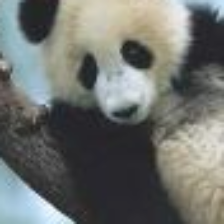

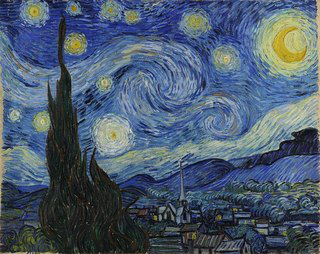

In [5]:
img_path = 'assets/panda.png' if os.path.exists('assets') else 'https://github.com/mlss-2019/tutorials/raw/master/deep_learning/assets/panda.png'
style_img_path = 'assets/starry.png' if os.path.exists('assets') else 'https://github.com/mlss-2019/tutorials/raw/master/deep_learning/assets/starry.png'

img = torch.tensor(np.transpose(plt.imread(img_path), [2, 0, 1])).unsqueeze(0)
display(Image(img_path))

panda_class, banana_class = 388, 954

style_img = torch.tensor(np.transpose(plt.imread(style_img_path), [2, 0, 1]))[:, :224, :224].unsqueeze(0)
display(Image(style_img_path))

## Model

We'll use a network that has already been trained on the Imagenet dataset, which we can download easily via `torchvision.models`. We'll use VGG-13, a fairly simple architecture with 13 layers. Since we want gradients on the input we can't use `torch.no_grad()`, but we want to avoid calculating gradients with respect to all of the parameters of the network. To avoid this, we'll loop over all of them, and set the property `requires_grad = False`.

All of the pretrained models available via `torchvision.models` use mean and standard deviation normalisation, so we'll make a small module to perform this for us while letting gradients go through it, and then add it to the bottom of the pretrained network using `nn.Sequential`. The `Normalise` module that we'll create will use `register_buffer` to keep track of variables that aren't meant for optimisation, which would otherwise be created by adding `nn.Parameter` attributes.

In [6]:
class Normalise(nn.Module):
    def __init__(self):
        super().__init__()
        self.register_buffer('mean_tensor', torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1))
        self.register_buffer('std_dev_tensor', torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1))

    def forward(self, img):
        return (img - self.mean_tensor) / self.std_dev_tensor

model = models.vgg13(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
model.eval()
model = nn.Sequential(Normalise(), model)

## Saliency Map

To examine what the network is looking at with respect to a certain class, we'll backpropagate a vector of gradients from the logits (un-normalised probabilities) of the network where the target class has a gradient of 1 and the other classes have gradients of 0. We'll then display the normalised saliency map.

Note that throughout these experiments we'll often manipulate tensor data (`x.data`) and gradients (`x.grad`) directly. There are neater ways of doing this (primarily using hooks), but we will make do for these small experiments.

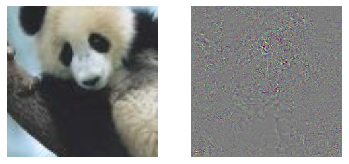

In [4]:
plt.axis('off')

x = torch.tensor(img, requires_grad=True)
class_grads = torch.zeros(1, 1000)
class_grads[0, panda_class] = 1
white_bar = torch.ones(3, 224, 50)

y = model(x)
autograd.backward(y, class_grads)
saliency = x.grad[0]
saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())
    
display(plt.imshow(np.transpose(torch.cat([img[0], white_bar, saliency], 2).numpy(), [1, 2, 0])))
clear_output(wait=True)

Using "vanilla" gradients tends not to work so well for saliency maps. Consider what this means for interpretability techniques in general - they are formed out of a sequence of well-defined mathematical operations, but we have to consider what exactly they entail.

For the (relatively common) case of networks with ReLU nonlinearities, a technique called "guided backpropagation" has been introduced to improve the results. Guided backpropagation involves clamping the negative gradients to 0, preventing gradient flow through neurons that would decrease the activation of the neuron we are trying to maximise. There's been plenty of further research on saliency map methods which we won't go into here.

We'll use the ability of PyTorch to insert hooks into a network in order to modify the gradients in the backwards pass, and then remove them afterwards to make sure that we can continue to use the network as normal.

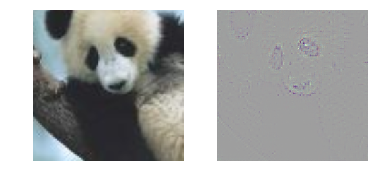

In [5]:
plt.axis('off')

# Hook that can be used to adjust gradients
def guided_backprop(module, grad_in, grad_out):
    return (torch.clamp(grad_in[0], min=0), )

# Apply hooks to appropriate modules (and keep hold of handles to remove them once done)
hook_handles = []
for module in model.modules():
    if isinstance(module, nn.ReLU):
        hook_handles.append(module.register_backward_hook(guided_backprop))

x = torch.tensor(img, requires_grad=True)

y = model(x)
autograd.backward(y, class_grads)
saliency = x.grad[0]
saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())

[handle.remove() for handle in hook_handles]
    
display(plt.imshow(np.transpose(torch.cat([img[0], white_bar, saliency], 2).numpy(), [1, 2, 0])))
clear_output(wait=True)

## Feature Visualisation

To visualise the sorts of features that the network responds to, we can start from random noise as input and then optimise this using gradient descent to maximise the activation of a given set of neurons in the network. However, networks are not restricted from having large responses to inputs well out of the data distribution, so doing this naively tends to produce high frequency noise. We use two adjustments here - normalising the gradients and blurring the input - in order to get more "natural" results (and there's been plenty more work on "natural image priors" that can create even better visualisations).

We want to maximise the mean activation of one convolutional filter, and to do so we'll construct three networks that contain a subset of the original network, such that the final output corresponds to a convolutional layer. While the earlier filters respond mainly to direction and colour, later layers respond to textures and even more complex motifs.

In [6]:
# Create models that take in a set number of (pretrained) layers from our network, sequentially from the bottom
cropped_model_1 = nn.Sequential(Normalise(), *[model[1].features[i] for i in range(6)])
cropped_model_2 = nn.Sequential(Normalise(), *[model[1].features[i] for i in range(13)])
cropped_model_3 = nn.Sequential(Normalise(), *[model[1].features[i] for i in range(23)])

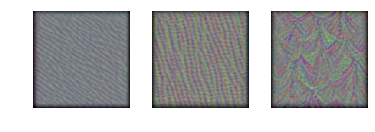

In [7]:
plt.axis('off')

x1 = torch.rand(1, 3, 224, 224, requires_grad=True)
x1.data.mul_(0.2).add_(0.4)
x2, x3 = torch.tensor(x1.detach(), requires_grad=True), torch.tensor(x1.detach(), requires_grad=True)
optimiser = optim.SGD([x1, x2, x3], lr=0.1)
filter_size = 5
box_filter = torch.ones(3, 1, filter_size, filter_size) / filter_size ** 2

for _ in range(20):
    optimiser.zero_grad()
    y1, y2, y3 = cropped_model_1(x1), cropped_model_2(x2), cropped_model_3(x3)
    loss = -(y1[:, 0, :, :].mean() + y2[:, 0, :, :].mean() + y3[:, 0, :, :].mean())
    loss.backward()
    # Normalise the gradients
    x1.grad /= (torch.sqrt(torch.mean(x1.grad.pow(2))) + 1e-5)
    x2.grad /= (torch.sqrt(torch.mean(x2.grad.pow(2))) + 1e-5)
    x3.grad /= (torch.sqrt(torch.mean(x3.grad.pow(2))) + 1e-5)
    optimiser.step()
    # Apply blurring to prevent high frequency noise
    x1.data = torch.nn.functional.conv2d(x1, box_filter, padding=filter_size // 2, groups=3).data
    x2.data = torch.nn.functional.conv2d(x2, box_filter, padding=filter_size // 2, groups=3).data
    x3.data = torch.nn.functional.conv2d(x3, box_filter, padding=filter_size // 2, groups=3).data
    # Clamp the data back into the [0, 1] range
    x1.data.clamp_(0, 1)
    x2.data.clamp_(0, 1)
    x3.data.clamp_(0, 1)

    visualisations = [x1[0].detach(), white_bar, x2[0].detach(), white_bar, x3[0].detach()]
    plt.imshow(np.transpose(torch.cat(visualisations, 2), [1, 2, 0]))
    display(plt.gcf())
    clear_output(wait=True)

## Deep Dream

The Deep Dream technique is exactly the same as feature visualisation, but starting from an existing image. Here we'll maximise the activations of a few filters at once. You'll see the network exaggerate some of the textures, and maybe even "hallucinate" some eyes.

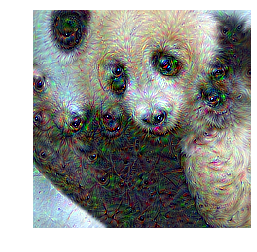

In [8]:
plt.axis('off')

x = torch.tensor(img, requires_grad=True)
for _ in range(20):
    y = cropped_model_3(x)
    loss = -y[:, :10, :, :].mean()
    loss.backward()
    x.grad /= (torch.sqrt(torch.mean(x.grad.pow(2))) + 1e-5)
    x.data += 0.02 * x.grad
    x.data.clamp_(0, 1)
    x.grad.zero_()
    plt.imshow(np.transpose(x[0].detach(), [1, 2, 0]))
    display(plt.gcf())
    clear_output(wait=True)

## Style Transfer

Style transfer creates a pastiche by optimising an input image to have similar content to one image, and similar style to another. For content, this corresponds to minimising the distance (typically Euclidean) between high-level features of the input image and content image in a trained CNN; we'll use a convolutional layer a little way in to preserve most spatial information and a slight bit of semantic information. For style, the Gram matrix (a matrix formed from all possible inner products of another given matrix) of the high-level features, is used instead - roughly speaking this represents correlations between features. We'll use a set of the first few convolutional layers to cover basic colour to brush strokes.

In contrast to many other tasks we encounter, we can perform gradient descent over the full "dataset". While typical first-order optimisers like SGD or Adam can be used for style tranfer, we'll use a second-order method - L-BFGS - which tends to work better (and won't need extensive tuning).

In [7]:
cropped_model_1 = nn.Sequential(Normalise(), *[model[1].features[i] for i in range(1)])
cropped_model_2 = nn.Sequential(Normalise(), *[model[1].features[i] for i in range(3)])
cropped_model_3 = nn.Sequential(Normalise(), *[model[1].features[i] for i in range(6)])
cropped_model_4 = nn.Sequential(Normalise(), *[model[1].features[i] for i in range(8)])

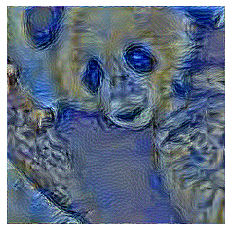

In [8]:
plt.axis('off')

def gram_matrix(x):
    b, c, h, w = x.size()
    x = x.view(b * c, h * w)
    return x @ x.t()

x = torch.rand(1, 3, 224, 224, requires_grad=True)
x.data.mul_(0.2).add_(0.4)
optimiser = optim.LBFGS([x])
content_feat = cropped_model_4(img)
style_feats = [gram_matrix(cropped_model_1(style_img)), gram_matrix(cropped_model_2(style_img)),
               gram_matrix(cropped_model_3(style_img)), gram_matrix(cropped_model_4(style_img))]

for _ in range(5):
    # Create a new closure for L-BFGS to use in optimisation
    def closure():
        optimiser.zero_grad()
        ys = [cropped_model_1(x), cropped_model_2(x), cropped_model_3(x), cropped_model_4(x)]
        content_loss = F.mse_loss(ys[3], content_feat)
        style_loss = sum(F.mse_loss(gram_matrix(y), style_feat) for y, style_feat in zip(ys, style_feats))
        (2e8 * content_loss + style_loss).backward()
        return 2e8 * content_loss.item() + style_loss.item()

    optimiser.step(closure)
    x.data.clamp_(0, 1)
    plt.imshow(np.transpose(x[0].detach(), [1, 2, 0]))
    display(plt.gcf())
    clear_output(wait=True)

## Adversarial Examples

While a trained network may be able to perform its task very well on the training set, or even the test set, it may still produce strange predictions outside of the training set distribution. The idea behind adversarial examples are that they have such an effect on networks, and one class of examples are noise images that produce very strong classification predictions. To demonstrate this, we'll use the basic feature visualisation technique on the logits of the network, and create a "truck" with over 99% confidence in at most 10 iterations.

Even more worryingly, adversarial examples can also be impercetible to humans. We can use gradient descent to perform untargeted attacks (simply trying to cause a misclassification), or even a targeted attack (making the network think that an image is of a specific other class). We'll use an targeted iterative fast gradient sign attack, turning the panda into a truck. With this, the probability that the image is of a panda drops very rapidly. After 5 iterations it's over 90% certain that it's a truck, and after 10 it's almost 100% certain. The (normalised) difference between the images will be displayed on the right.

Adversarial attacks and defences are an ongoing area of research, with no great solution in sight against attacks - the best so far seems to be generating and training on adversarial examples, but this doesn't make networks completely foolproof. The notion of adversarial examples can also extend to other tasks, such as generative modelling or reinforcement learning. Finally, here we looked at a *white-box* attack, where we knowledge of and access to the model, but there also exist *black-box* attacks, where the attacker only has access to the inputs and outputs of the model, and has no knowledge of the internal workings.

'Probability that input is banana: 96.65%'

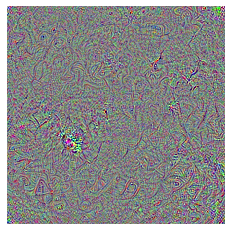

In [6]:
plt.axis('off')

x = torch.rand(1, 3, 224, 224, requires_grad=True)
x.data.mul_(0.2).add_(0.4)
class_grads = torch.zeros(1, 1000)
class_grads[0, banana_class] = 1

for _ in range(10):
    y = model(x)
    prob = F.softmax(y, dim=1)[0, banana_class].item()
    autograd.backward(y, class_grads)
    x.data += x.grad
    x.data.clamp_(0, 1)
    x.grad.zero_()
    
    plt.imshow(np.transpose(x[0].detach(), [1, 2, 0]))
    display(plt.gcf())
    display('Probability that input is banana: %.2f%%' % (prob * 100))
    clear_output(wait=True)

display('Probability that input is banana: %.2f%%' % (prob * 100))

'Probability that input (middle image) is banana: 99.73%'

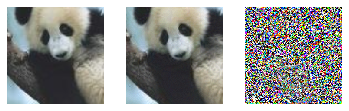

In [7]:
plt.axis('off')

x = torch.tensor(img, requires_grad=True)

for _ in range(10):
    y = model(x)
    prob = F.softmax(y, dim=1)[0, banana_class].item()
    autograd.backward(y, class_grads)
    x.data += 0.001 * x.grad[0].sign()
    x.data.clamp_(0, 1)
    
    img_diff = img[0] - x[0]
    img_diff = (img_diff - img_diff.min()) / (img_diff.max() - img_diff.min())
    plt.imshow(np.transpose(torch.cat([img[0], white_bar, x.data[0], white_bar, img_diff.data], 2).numpy(), [1, 2, 0]))
    display(plt.gcf())
    display('Probability that input (middle image) is banana: %.2f%%' % (prob * 100))
    clear_output(wait=True)

display('Probability that input (middle image) is banana: %.2f%%' % (prob * 100))